In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py

import sscCdi

### Load example data

In [2]:
data = np.load('../data/ptycho/data.npy')
positions = np.load('../data/ptycho/positions.npy')

### Define initial object and initial probe, if wanted

In [3]:
initial_obj = None
initial_probe = None

### Ptychography. Options are:

    - RAAR_PYTHON: Relaxed Averaged Alternating Reflections. Single GPU, Python implementation using CuPy
    - ePIE_PYTHON: Extended Ptychographic Iterative Engine. Single GPU, Python implementation using CuPy
    - RAAR_CUDA:   Relaxed Averaged Alternating Reflections. Multi GPU, CUDA implementation
    - AP_CUDA:     Alternate Projections. Multi GPU, CUDA implementation
    - AP_PC_CUDA:  Alternate Projections with Position Correction via Annealing method. Multi GPU, CUDA implementation
    - ePIE_CUDA:   Extended Ptychographic Iterative Engine. Single GPU, CUDA implementation

### Args:
    - DPs (ndarray): diffraction data with shape (N,Y,X). N is the number of diffraction patterns.
    - positions (array): positions array with shape (N,2) with (x,y) position pairs in each line.
    - initial_obj (ndarray, optional): Initial guess for object. Shape to be determined from DPs and positions. If None, will use the input in "input_dict" to determine the initial object. Defaults to None.
    - initial_probe (ndarray, optional): Initial guess for probe of shape (M,Y,X), where M is the number of probe modes. If None, will use the input in "input_dict" to determine the initial probe. Defaults to None.
    - input_dict (dict): dictionary of input required for Ptychography. See dicitonary of inputs in the next cell.


### Returns:
    - obj: object matrix 
    - probe: probe matrix
    - error: error metric along iterations
    - positions: final positions of the scan (which may be corrected if AP_PC_CUDA is used)


In [4]:
input_dict = {

    "hdf5_output": './output.h5',
    
    'CPUs': 32,  # number of cpus to use for parallel execution    
    'GPUs': [0], # list of numbers (e.g. [0,1,2]) containg the number of the GPU

    "fresnel_regime": False,
    
    'energy': 6, # energy in keV
    
    'detector_distance': 13, # meters
    
    'distance_sample_focus': 0, # float. Distance in meters between sample and focus or pinhole. This distance is used to propagated the probe prior to application of the probe support. 
    
    'detector_pixel_size': 55e-6, # meter
    
    'binning': 1, # how many times to bin data. Must be even number. if 1, no binning.
    
    'position_rotation': 0, # angle in radians. Rotation angle between detector and probe transverse coordinates

    'object_padding': 50, # pixels. Number of pixels to add around the object matrix

    'incoherent_modes': 1, # int. Number of incoherent modes to use

    'probe_support': {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} , # support to be applied to the probe matrix after probe update. Options are:
                                                                                           # - {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} (0,0) is the center of the image
                                                                                           # - {"type": "cross",  "center_width": 300,  "cross_width": 0, "border_padding": 0} 

    "initial_obj": ["random"], # 2d array. Initial guess for the object. Options are:
                               # - path to .npy, 
                               # - path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                               # - ["random"], random matrix with values between 0 and 1
                               # - ["constant"], constant matrix of 1s

    "initial_probe": ["inverse"], # 2d array. Initial guess for the probe. Options are:
                                  # - path to .npy, 
                                  # - path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                  # - ["random"], random matrix with values between 0 and 1
                                  # - ["constant"], constant matrix of 1s
                                  # - ["inverse"], matrix of the Inverse Fourier Transform of the mean of DPs.
                                  # - ["circular",radius,distance], circular mask with a pixel of "radius". If a distance (in meters) is given, it propagated the round probe using the ASM method.

    'Algorithm1': {'Batch': 64,
                    'Beta': 0.995,
                    'Epsilon': 0.01,
                    'Iterations': 10,
                    'Name': 'RAAR',
                    'ProbeCycles': 4,
                    'TV': 0},

#     'Algorithm2': {'Batch': 64,
#                     'Epsilon': 0.01,
#                     'Iterations': 50,
#                     'Name': 'GL',
#                     'ObjBeta': 0.97,
#                     'ProbeBeta': 0.95,
#                     'TV': 0.0001},

#     'Algorithm2': {'Batch': 64,
#                     'Epsilon': 0.01,
#                     'Iterations': 50,
#                     'Name': 'positioncorrection',
#                     'ObjBeta': 0.97,
#                     'ProbeBeta': 0.95,
#                     'TV': 0.0001},

#     'Algorithm3': { 'Name': 'PIE',
#                     'Iterations': 100,
#                     'step_obj': 0.5,    # step size for object update
#                     'step_probe': 1,    # step size for probe update
#                     'reg_obj': 0.25,    # regularization for object update
#                     'reg_probe': 0.5,   # regularization for probe update
#                     'Batch':1}


'algorithms': {
    
'1': {'name': 'ePIE_python',
        'iterations': 10,
        'regularization_object': 0.25,
        'regularization_probe': 0.5,
        'step_object': 0.5,
        'step_probe': 1,
        'use_mPIE': False,
        'mPIE_friction_obj': 0.9,
        'mPIE_friction_probe': 0.99,
        'mPIE_momentum_counter': 10,
        },
'2': {'name': 'ePIE_python',
        'iterations': 10,
        'regularization_object': 0.25,
        'regularization_probe': 0.5,
        'step_object': 0.5,
        'step_probe': 1,
        'use_mPIE': False,
        'mPIE_friction_obj': 0.9,
        'mPIE_friction_probe': 0.99,
        'mPIE_momentum_counter': 10,
        },
    		    
    

}}



In [5]:
positions = np.roll(positions,axis=1,shift=1)
positions.shape

(81, 2)

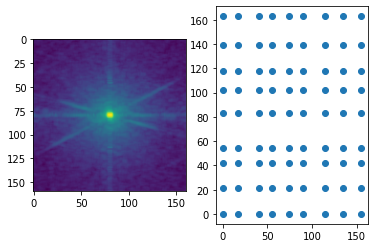

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(data.mean(0),norm=LogNorm())
ax[1].plot(positions[:,0],positions[:,1],'o')

In [7]:
recon_obj, recon_probe, recon_error, recon_positions = sscCdi.call_ptychography(input_dict,data, positions, initial_obj=initial_obj, initial_probe=initial_probe)

Pixel size = 55.00 um
Energy = 6 keV
Wavelength = 0.207 nm
Object pixel = 305.26 nm
Object shape: (365, 373)
Creating initial probe...
Probe shape (160,160) with 1 incoherent mode(s)
Creating initial object...
Setting probe support...
Calling 10 iterations of ePIE algorithm...
Calling 10 iterations of ePIE algorithm...
Calling 10 iterations of ePIE algorithm...


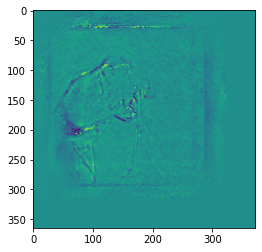

In [8]:
plt.figure()
plt.imshow(np.angle(recon_obj[0]))